In [11]:
import numpy as np
import pandas as pd

%run settings/plt_settings.ipynb
%run settings/db_connect.ipynb

# $P_L$

In [2]:
dis40 = sql(r"""select * from valid_proteins where len >= 40""")
dis40.head()

,len,dis40,dis40_random,dis40_uniform
ac,,,,
A0A060X6Z0,489,True,True,False
A0A068FIK2,1033,True,True,False
A0A075F932,421,True,False,False
A0A078CGE6,1299,True,True,False
A0A086F3E3,192,False,True,False


In [3]:
def generate_PL(df, column):
    from functools import lru_cache
    
    df = pd.DataFrame(df[['len', column]])
   
    @lru_cache(maxsize=None)
    def _PL(L):
        eps = round(0.1*L)
        return df[ (df.len >= L-eps) & (df.len <= L+eps) ].mean()[column]
        
    _PL.df = df
    _PL.raw = df.groupby('len').mean()  # da bi kasnije mogao da se referisem na njega
    
    return _PL
  
PL = generate_PL(dis40, 'dis40')
PL_random = generate_PL(dis40, 'dis40_random')
PL_uniform = generate_PL(dis40, 'dis40_uniform')

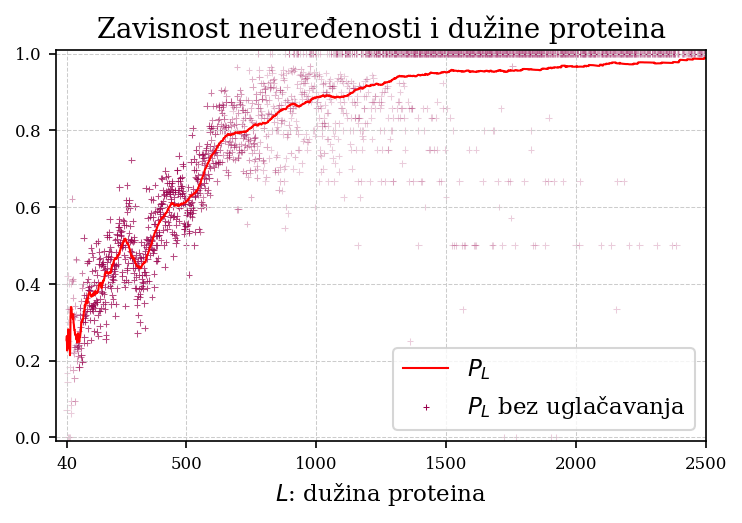

In [4]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])

ax.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')

xs_count = PL.df.groupby('len').count().dis40
xs_color = [(0.6,0,0.3, max(min(n/100,0.7),0.2) ) for n in xs_count]
ax.scatter( PL.raw.index,  PL.raw.dis40, label='$P_L$ bez uglačavanja'
            , marker='+', color=xs_color, linewidth=0.5, s=10)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnost neuređenosti i dužine proteina')
ax.set_xlabel("$L$: dužina proteina")

leg =ax.legend()
leg.legendHandles[1].set_color((0.6,0,0.3))

plt.savefig('plots/PL_F.pdf', dpi=300)

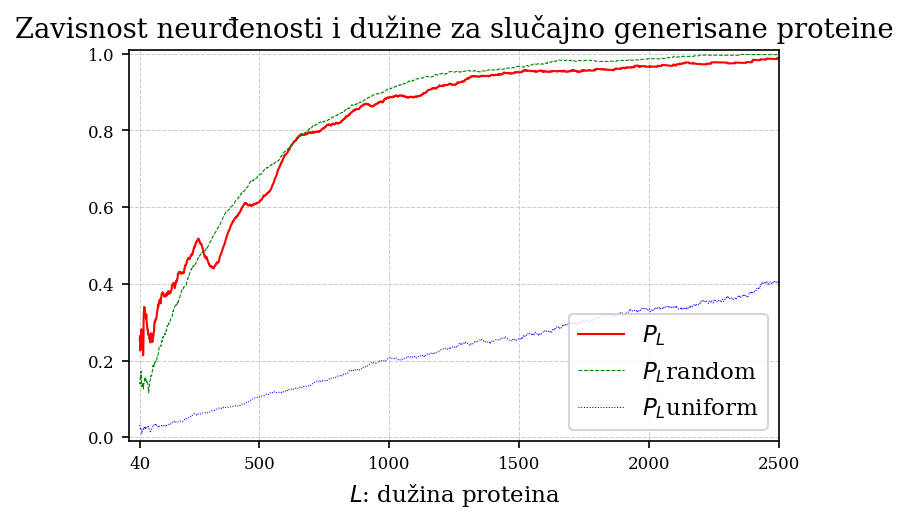

In [5]:
fig, ax = plt.subplots() 

xs = np.arange(40, 2500)
ys = np.array([PL(x) for x in xs])
ys_random = np.array([PL_random(x) for x in xs])
ys_uniform = np.array([PL_uniform(x) for x in xs])

plt.plot(xs, ys, 'r-', linewidth=1, label='$P_L$')
plt.plot(xs, ys_random, 'g--', linewidth=0.5, label='$P_L$random')
plt.plot(xs, ys_uniform, 'b:', linewidth=0.5, label='$P_L$uniform')

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0, 2500)
ax.set_xticks([40]+list(range(0, 2501, 500))[1:])

ax.set_title('Zavisnost neurđenosti i dužine za slučajno generisane proteine')
ax.set_xlabel("$L$: dužina proteina")

plt.legend(loc='lower right' )

plt.savefig('plots/PL_F_cmp.pdf', dpi=300)

# Dis

In [26]:
Fj_kw_raw = sql(r"""
select kw, name
     , count(kw) n
     , avg(len) avg_len
     , avg(dis40::int) avg_dis
     , array_agg(len) length_list
     
from valid_proteins
    join prot2kw on ac=prot
    join keywords on keywords.ac=prot2kw.kw

where true
  and category = 'KW-9992' -- Molecular function
  and len >=40             

group by (kw, name)
""")
Fj_kw_raw.head()

,name,n,avg_len,avg_dis,length_list
kw,,,,,
KW-0008,Acetylcholine receptor inhibiting toxin,12,70.750000,0.250000,"[109, 69, 64, 60, 58, 111, 62, 69, 64, 64, 60,..."
KW-0009,Actin-binding,837,974.918757,0.768220,"[730, 1538, 492, 1141, 490, 1141, 821, 1315, 1..."
KW-0010,Activator,2574,600.510101,0.878788,"[238, 187, 532, 201, 775, 345, 376, 2581, 1310..."
KW-0012,Acyltransferase,867,531.583622,0.422145,"[1189, 381, 484, 512, 184, 445, 323, 168, 170,..."
KW-0022,Alpha-amylase inhibitor,3,166.333333,0.000000,"[146, 153, 200]"


In [14]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [34]:
%%cython -f
from libc.stdlib cimport rand, srand, RAND_MAX

srand(0);
  
cdef float random1():
    return rand()/float(RAND_MAX)

def calcYj(PL_list):
    cdef int i = 0
    cdef float l
    for PL_instance in PL_list:
        if random1() < PL_instance:
            i+=1
    return i/len(PL_list)

In [42]:
def calc_stat(Fj, PL):
    from tqdm import tqdm

    stat_info = []

    for index, row in tqdm(Fj.iterrows(), total=len(Fj), ):
        PL_list = [ PL(l) for l in row['length_list']]
        Yj_realisations = np.array( [calcYj(PL_list) for _ in range(1000)] )
        p = (Yj_realisations > row.avg_dis).mean()  # empirical

        p = 1-p # ovo moram da hakujem da  bi bse poklapalo sa tabelama u radu, ne znam zasto je tako ???

        Yj_mean = Yj_realisations.mean()
        Yj_std  = Yj_realisations.std() #or 0.0000001

        z = (row.avg_dis - Yj_mean) / Yj_std
        #pp = 1/2*(1 - math.erf(z/2))
        #print('go:', go, 'p:', p, mean, std, z, 'pp:', pp)   
        stat_info.append((index, z, p))

    stat_info = pd.DataFrame(stat_info, columns=['index', 'z', 'p']).set_index('index')
    return  pd.DataFrame(Fj[Fj.columns[:-1]]).join(stat_info)

In [43]:
Fj_kw_stat = calc_stat(Fj_kw_raw, PL)

100%|██████████| 186/186 [00:10<00:00, 18.16it/s]


In [387]:
Fj_kw_valid = (Fj_kw_stat.query(' p<0.05 or p>0.95')
                         .sort_values('z', ascending=False))
Fj_kw_valid.head()

,name,n,avg_len,avg_dis,z,p
kw,,,,,,
KW-0238,DNA-binding,6518,546.531912,0.871126,46.904973,1.0
KW-0217,Developmental protein,3897,655.208622,0.859379,31.096980,1.0
KW-0010,Activator,2574,600.510101,0.878788,28.115824,1.0
KW-0678,Repressor,1988,589.294769,0.852113,22.628029,1.0
KW-0694,RNA-binding,2728,575.764296,0.763563,16.617519,1.0


In [61]:
import pygraphviz as pgv
from IPython import display
from pprint import pprint

In [86]:
%load_ext dotmagic

In [534]:
def nice_str(x):
    import numpy as np
    if type(x) is object:
        return x[:-7]+"..." if len(x)>10 else x
        
    if type(x) is np.float64:
        x = "%0.2f"%x 
    x = str(x)
    if x == '1.00': x = '1'
    if x == '0.00': x = '0'
    if len(x) > 30: x = x[:27]+'...'
    return x

def df2html(df):
    rows_list = []
    rows_list.append( '<tr><td>#</td>' + ' '.join([f"<td><i>{col_name}</i></td>" for col_name in df.columns]) + '</tr>')
    for i,(_, *xs) in enumerate(df.itertuples()):
        td_list = [ f'<td port="{xs[0]}_left">{i+1}</td>' ]
        td_list += [f'<td>{nice_str(x)}</td>' for x in xs[:-1]]
        td_list += [ f'<td port="{xs[0]}_right">{nice_str(xs[-1])}</td>' ]

        rows_list.append( f'<tr>' + ' '.join(td_list) + '</tr>' )
    
    table_str =  '<<table border="0" cellborder="1" cellspacing="0" title="VAL" >\n' +\
                 '\n'.join(rows_list)                                   +\
                 '\n</table>>'
    return table_str

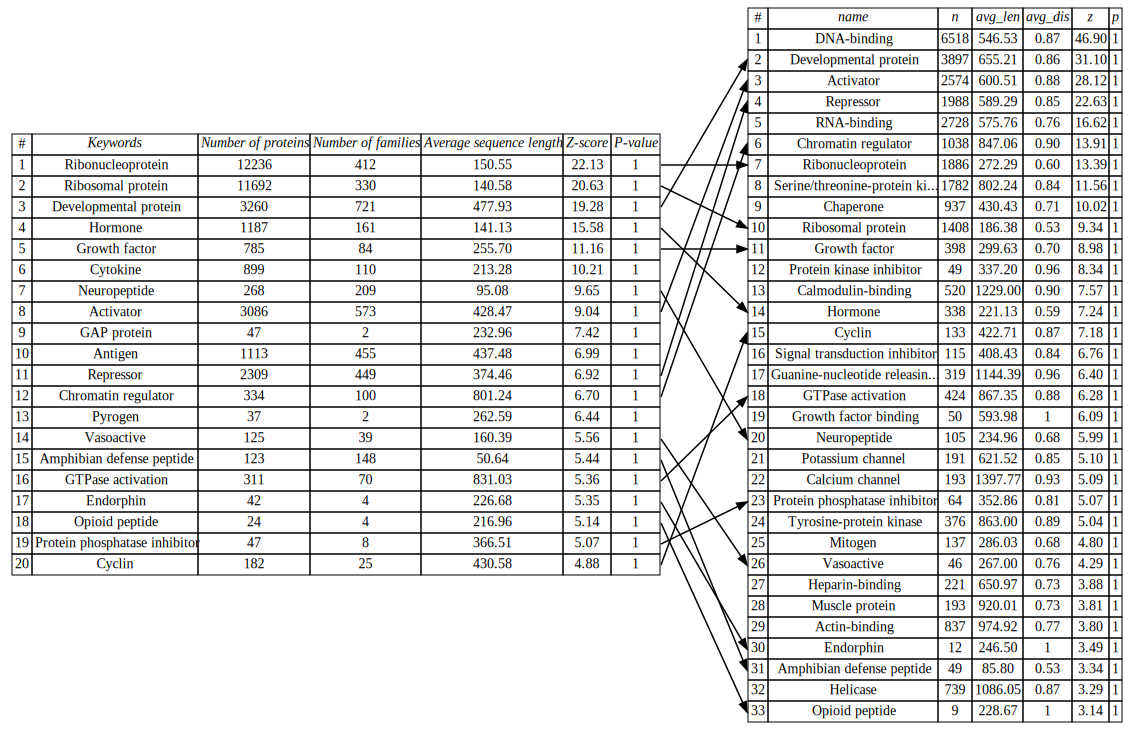

In [535]:



top20dis = Fj_kw_valid[:33]
top20dis2007 = pd.read_csv('data/IN/top20dis2007.csv')
#top20dis['id'] = top20dis.index

G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='false',nodesep=0, ranksep=1 )
G.add_node("A", label=df2html(top20dis2007), shape='none')
G.add_node("B", label=df2html(top20dis), shape='none')

ports = set.intersection( set(top20dis2007.Keywords),  set(top20dis.name) )
for port in ports:
    G.add_edge('A', 'B', tailport=port+'_right', headport=port+'_left', penwidth=1.5)
#print(G)
G.layout(prog='dot')
#G.draw('plots/KWtop20dis.pdf', format='pdf')
display.display_svg(G.draw(format='svg'), raw=True)

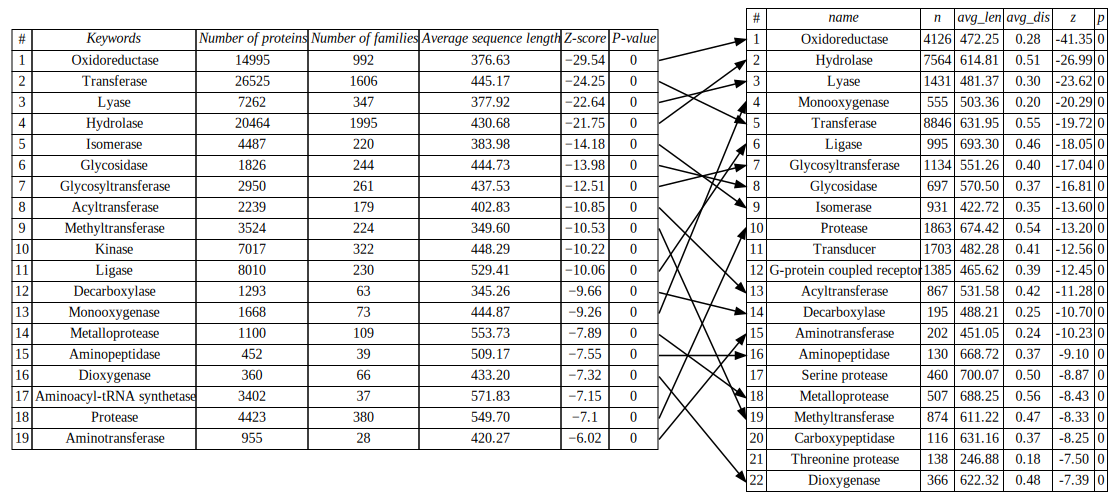

In [536]:
top20ord2007 = pd.read_csv('data/IN/top20ord2007.csv')
top20ord = Fj_kw_valid.sort_values('z', ascending=True) [:22]


G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='false',nodesep=0, ranksep=1 )
G.add_node("A", label=df2html(top20ord2007), shape='none')
G.add_node("B", label=df2html(top20ord), shape='none')

ports = set.intersection( set(top20ord2007.Keywords),  set(top20ord.name) )
for port in ports:
    G.add_edge('A', 'B', tailport=port+'_right', headport=port+'_left',  penwidth=1.5)
    
#print(G)
G.layout(prog='dot')
G.draw('plots/KWtop20ord.pdf', format='pdf')
display.display_svg(G.draw(format='svg'), raw=True)

****

In [462]:
Fj_kw_stat_random = calc_stat(Fj_kw_raw, PL_random)

100%|██████████| 186/186 [00:10<00:00, 17.63it/s]


In [468]:
Fj_kw_valid_random = (Fj_kw_stat_random.query(' p<0.05 or p>0.95')
                                       .sort_values('z', ascending=False))


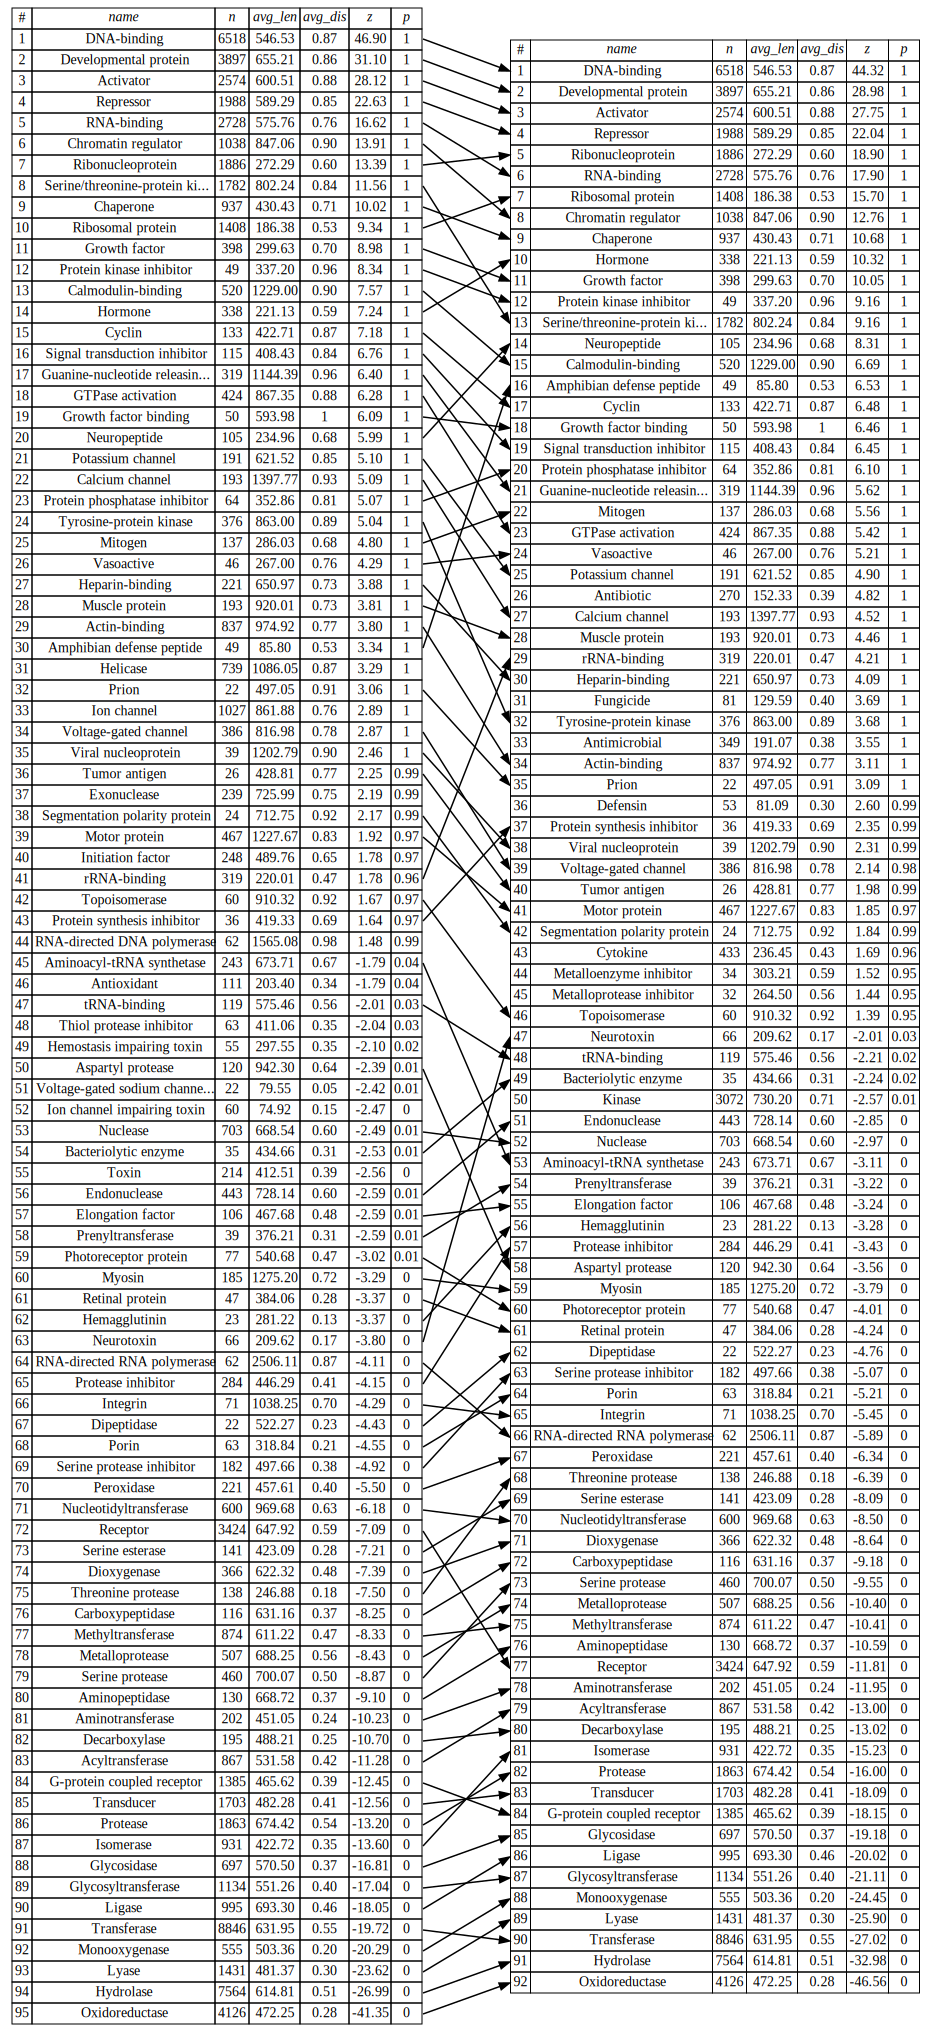

In [544]:
G = pgv.AGraph(directed=True, rankdir='LR', strict=False, splines='false',nodesep=0, ranksep=1 )
G.add_node("valid", label=df2html(Fj_kw_valid.query("n>19")), shape='none')
G.add_node("random", label=df2html(Fj_kw_valid_random.query("n>19")), shape='none')


ports = set.intersection( set(Fj_kw_valid.query("n>19").name),  set(Fj_kw_valid_random.query("n>19").name) )
for port in ports:
    G.add_edge('valid', 'random', tailport=port+'_right', headport=port+'_left', penwidth=1.5)
    
   
#print(G)
G.layout(prog='dot')
G.draw('plots/KW_random.pdf', format='pdf')
display.display_svg(G.draw(format='svg'), raw=True)